In [1]:
from qiskit import *;
from qiskit.tools.visualization import plot_histogram;
from qiskit import IBMQ;
from qiskit.tools.monitor import job_monitor;

In [2]:
qr = QuantumRegister(5);
cr = ClassicalRegister(5);

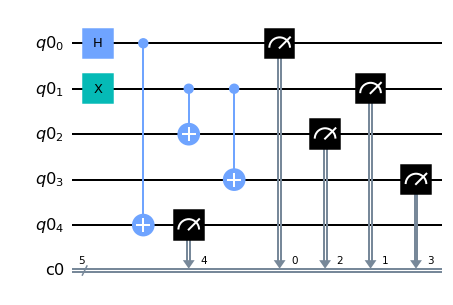

In [3]:
circuit = QuantumCircuit(qr,cr);

circuit.h(0);
circuit.cx(0,4);
circuit.x(1);
circuit.cx(1,2);
circuit.cx(1,3);

circuit.measure([0,1,2,3,4],[0,1,2,3,4]);

circuit.draw()

{'11111': 505, '01110': 519}


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


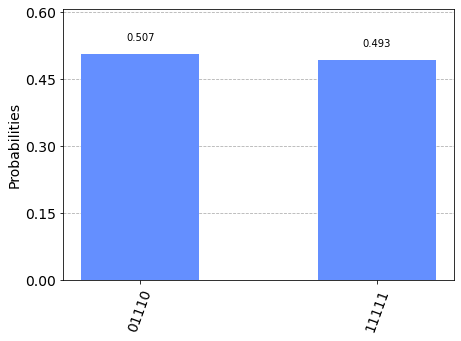

In [4]:
simulator = Aer.get_backend('qasm_simulator');

result = execute(circuit,backend = simulator, shots = 1024).result();

counts = result.get_counts(circuit);

print(counts);

plot_histogram(counts)

In [6]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [7]:
provider = IBMQ.get_provider(hub = "ibm-q");
for backend in provider.backends(): 
    try: 
        qubit_count = len(backend.properties().qubits);
    except: 
        qubit_count = "simulated";
    
    print(f"{backend.name()} has {backend.status().pending_jobs} queued and {qubit_count} qubits")

ibmq_qasm_simulator has 17 queued and simulated qubits
ibmq_armonk has 0 queued and 1 qubits
ibmq_lima has 31 queued and 5 qubits
ibmq_belem has 24 queued and 5 qubits
ibmq_quito has 39 queued and 5 qubits
simulator_statevector has 17 queued and simulated qubits
simulator_mps has 16 queued and simulated qubits
simulator_extended_stabilizer has 16 queued and simulated qubits
simulator_stabilizer has 16 queued and simulated qubits
ibmq_manila has 224 queued and 5 qubits
ibm_oslo has 8 queued and 7 qubits


In [8]:
device = provider.get_backend('ibmq_belem')

In [9]:
job = execute(circuit, backend = device, shots = 1024);
print(job.job_id());
job_monitor(job)

62ae4c05ed34ef1103527876
Job Status: job has successfully run


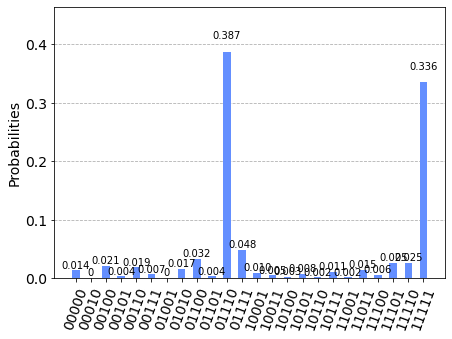

In [10]:
device_result = job.result();
counts = device_result.get_counts(circuit);
plot_histogram(counts)

In [11]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

/tmp/ipykernel_575/1503385324.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)


In [12]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

In [13]:
cal_job = execute(cal_circuits, backend = device, shots = 1024, optimization_level = 0);
print(cal_job.job_id());
job_monitor(cal_job);
cal_results = cal_job.result()

62ae504189d7929b7d5eab8e
Job Status: job has successfully run


In [14]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels);
meas_filter = meas_fitter.filter;
mitigated_result = meas_filter.apply(result)

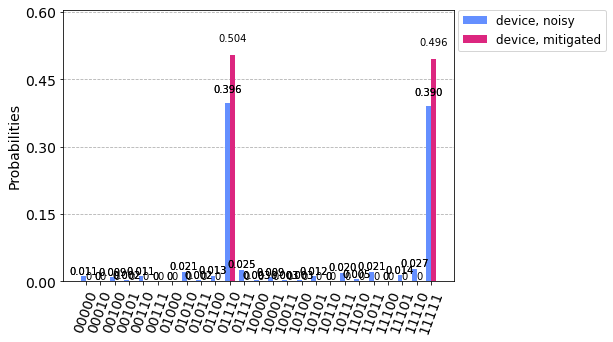

In [17]:
mitigated_counts = mitigated_result.get_counts(circuit);
plot_histogram([counts, mitigated_counts], legend = ['device, noisy', 'device, mitigated'])

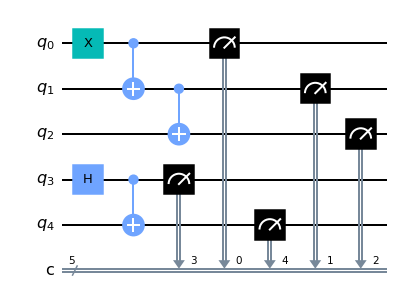

In [18]:
circuit2 = QuantumCircuit(5,5);
circuit2.x(0);
circuit2.cx(0,1);
circuit2.cx(1,2);
circuit2.h(3);
circuit2.cx(3,4);
circuit2.measure([0,1,2,3,4],[0,1,2,3,4]);
circuit2.draw()

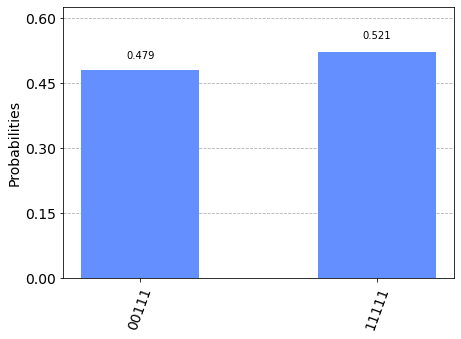

In [19]:
plot_histogram(execute(circuit2, backend = simulator, shots = 1024).result().get_counts(circuit2))

In [20]:
device_counts_2 = execute(circuit2, backend = device, shots = 1024).result().get_counts(circuit2);
plot_histogram(device_counts_2)

In [22]:
device_mitigated_counts_2 = meas_filter.apply(device_counts_2);
plot_histogram(device_mitigated_counts_2)

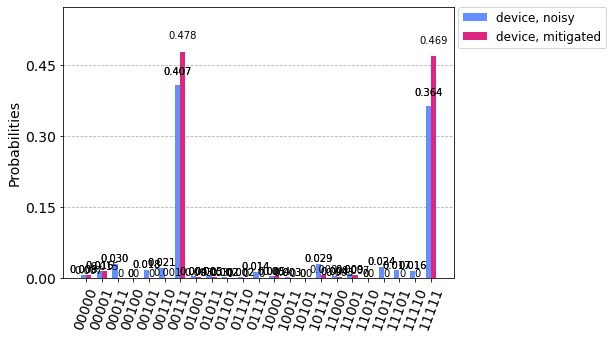

In [24]:
plot_histogram([device_counts_2, device_mitigated_counts_2], legend = ['device, noisy', 'device, mitigated'])